# FeatureNet classification Replication in Pytorch
- In this notebook we are trying to replicate the result of the paper https://www.sciencedirect.com/science/article/pii/S0010448518301349. 
- The code for the FeatureNet neural network for TensorFlow2 and the dataset can be seen here: https://gitlab.com/qub_femg/machine-learning/featurenet-tensorflow-2
- This code is part of my paper "Manufacturing Feature Recognition with a Sparse Voxel-based Convolutional Neural Network" Where I compare feature with octree-based neural network. 
- You can find my paper here  https://asmedigitalcollection.asme.org/computingengineering/article/25/3/031002/1210226.


## Step 1: Dataset

- My dataset is prepared and stored in train, val, and test with 70,15, and 15 split for each features.
- In this section, I just want to define the dataloader and then use it for the network training. 

In [ ]:
import yaml
import math
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import random


import binvox_rw

# load configuration of this neural network
flags = yaml.safe_load(open('FN_param.yaml'))

Here we create define the function that reads the dataset and create a filelist.
For the file list you can use different ratio which define how much dataset is used in the file list.

In [ ]:
# The Ratio means what ratio of data you want to put in the filelist and
# use it for training and testing

def get_filelist(root_folder, subfolder, suffix='off', ratio=1.0):
  filelist, category = [], []
  folders = sorted(os.listdir(root_folder))
  assert (len(folders) == flags['Data']['num_class'])
  
  for idx, folder in enumerate(folders):

    current_folder = os.path.join(root_folder, folder, subfolder)
    filenames = sorted(os.listdir(current_folder))
    filenames = [fname for fname in filenames if fname.endswith(suffix)]
    total_num = math.ceil(len(filenames) * ratio)
    
    for i in range(total_num):
      filelist.append(os.path.join(folder, subfolder, filenames[i]))
      
      # This code is good for the featureNet dataset
      category.append(int(filenames[i].split('_')[0]))
      
  
  return filelist, category

Here we create filelist.

In [23]:
# let's create a filelist of our data
list_folder = os.path.join(flags['Data']['root_dir'], 'vox-filelist')
if not os.path.exists(list_folder):
    os.makedirs(list_folder)

ratios = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
for folder in ['train', 'val', 'test']:
    for ratio in ratios:
      
      filename = os.path.join(list_folder, 'FN_%.02f_%s.txt' % (ratio, folder))
      filelist, idx = get_filelist(flags['Data']['vox_dir'],
                                   subfolder=folder, suffix='binvox',
                                   ratio=ratio)
      
      with open(filename, 'w') as fid:
        for i in range(len(filelist)):
          fid.write('%s %d\n' % (filelist[i], idx[i]))
      



This is the dataset loader that I used in this datasetloader I implemented a rotation function but I am not using in my studies.

In [ ]:
class featurenet_loader(Dataset):
    def __init__(self, flags, operation, normal, rotation):
        """
        Args:
            data_root (str): Root path for the folder containing voxelized data

        """
        # self.data_dir = data_dir   
        self.sample_paths, self.sample_labels = self.load_paths_with_labels(flags['Data'][operation]['filelist'])
        self.normal = normal
        self.rotation = rotation
              
    def load_paths_with_labels(self, filelist):
        
        
        with open(filelist, 'r') as file:
            filelist = [line.rstrip('\n') for line in file.readlines()]

        sample_paths = []
        sample_labels = []
        
        for name in filelist:
            parts = name.split(' ')
            path = parts[0] if len(parts) > 0 else None
            label = int(parts[1]) if len(parts) > 0 else None
            
            if label is not None:
                sample_labels.append(label)
            
            if label is not None:
                sample_paths.append(path)   
        
        return sample_paths, sample_labels
    
    # defining all the rotation
    def rot1(self, data):
        data[0] = data[0]
        return data

    def rot2(self, data):

        data[0] = np.rot90(data[0], 1, (1,2))
        return data

    def rot3(self, data):

        data[0] = np.rot90(data[0], 2, (1,2))
        return data

    def rot4(self, data):

        data[0] = np.rot90(data[0], 3, (1,2))
        return data

    def rot5(self, data):

        data[0] = np.rot90(data[0], 1, (0,1))
        return data

    def rot6(self, data):
        
        data[0] = np.rot90(data[0], 3, (0,1))
        return data
    
    def __getitem__(self, idx):
        """
        This is a default function that is triggered during training process to convert data into readable array in Pytorch
        Args:
            idx(int): index of the datapoint in the dataset (default is randomized during dataloading)
        Returns:
            (filepath, functional class index, manufacturing class index, material specification)
        """
        
        path = os.path.join(flags['Data']['vox_dir'], self.sample_paths[idx])
        
        with open(path, 'rb') as file:

            data = binvox_rw.read_as_3d_array(file).data
            data = data[np.newaxis, :]
            is_all_zero = np.all((data == 0))
            if is_all_zero:
                print(path)
            # rotating data 

            if self.rotation:

                rot = [self.rot1, self.rot2, self.rot3, self.rot4, self.rot5, self.rot6] 
                selected_rot = random.choice(rot)
                
                data = selected_rot(data)
            
            # Rescaling data between -1, 1
            if self.normal:
                data = (data - 0.5) * 2
        
        return data,  self.sample_labels[idx]

    def __len__(self):
        """
        Returns:
            length of the dataset
        """
        return len(self.sample_paths)
    
    

    


let's load the dataset.

In [ ]:
dataset = featurenet_loader(flags, operation='train', normal=False, rotation=False)

dataloader = DataLoader(dataset=dataset, batch_size=flags['Data']['train']['batch_size'], shuffle=True)

print("dataset lenght: " + str(len(dataset)))
print("dataloader lenght: " + str(len(dataloader)))

dataiter = iter(dataloader)
data = dataiter.__next__()

print("Input shape :" + str(data[0].shape))
print("Output shape :" + str(data[1].shape))
print(data)



dataset lenght: 16798
dataloader lenght: 525
Input shape :torch.Size([32, 1, 64, 64, 64])
Output shape :torch.Size([32])
[tensor([[[[[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           ...,
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]],

          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           ...,
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]],

          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  Tr

Let's see whether our rotation works properly.

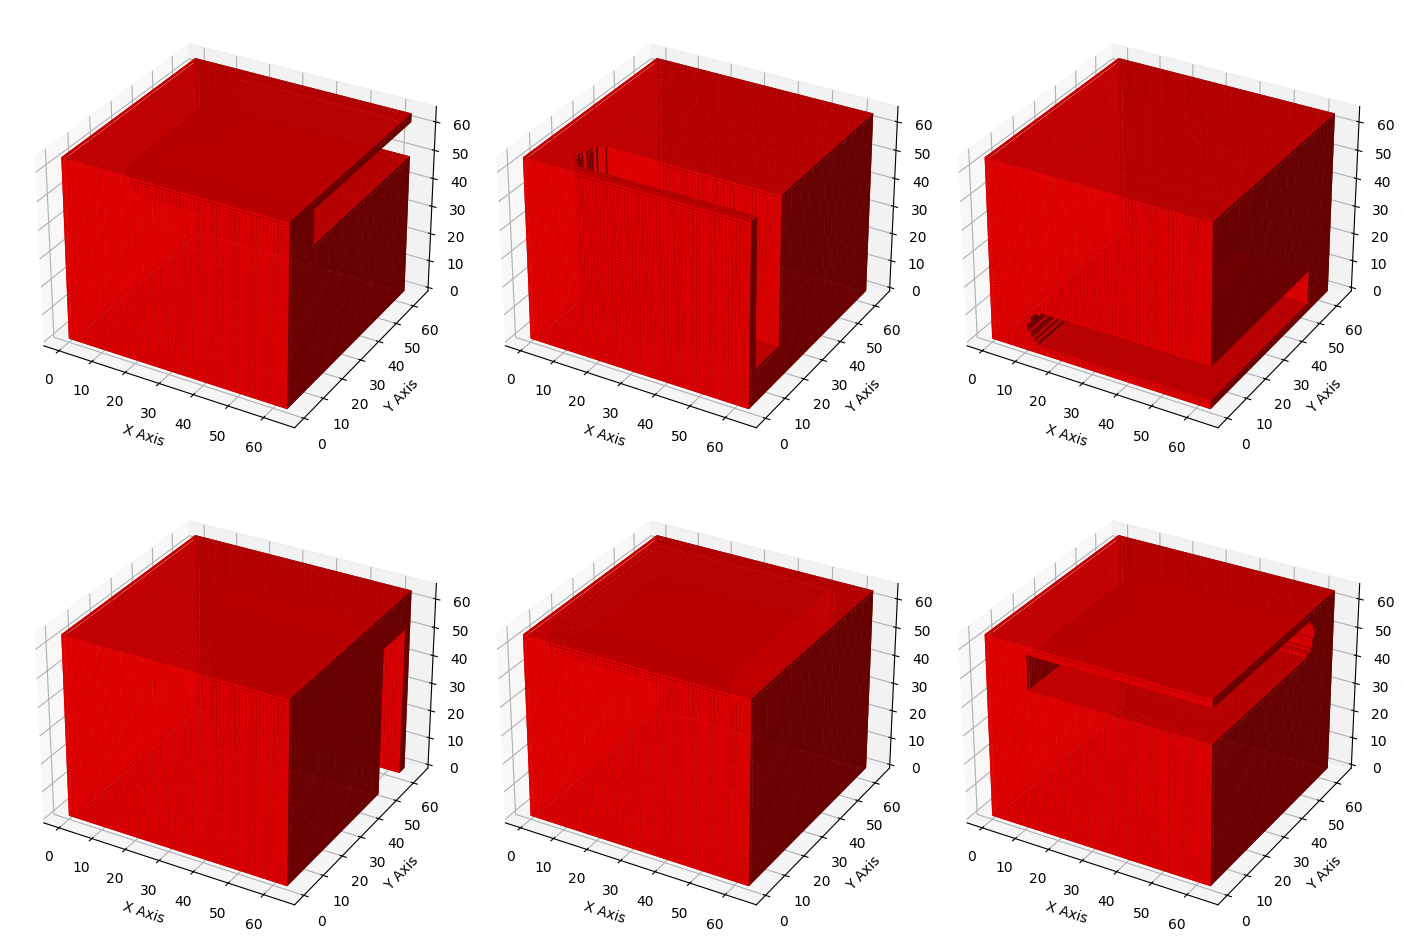

In [ ]:

# Replace this tensor with your actual voxel data
voxel_tensor = data[0]  # Your tensor data goes here

# Convert the tensor to a NumPy array
voxel_arrays = voxel_tensor.cpu().numpy()

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(14, 10), subplot_kw={'projection': '3d'})  # 2 rows, 3 columns


voxel_array = voxel_arrays[1][0]
    
voxel_rotate2 = np.rot90(voxel_array, 1, (1, 2))
voxel_rotate3 = np.rot90(voxel_array, 2, (1, 2))
voxel_rotate4 = np.rot90(voxel_array, 3, (1, 2))
voxel_rotate5 = np.rot90(voxel_array, 1, (0,1))
voxel_rotate6 = np.rot90(voxel_array, 3, (0,1))

        
axes[0, 0].voxels(voxel_array, facecolors='r', linewidth=0.01, edgecolor='k')  # Example plot data
axes[0, 0].set_xlabel('X Axis')
axes[0, 0].set_ylabel('Y Axis')
axes[0, 0].set_zlabel('Z Axis')

axes[0, 1].voxels(voxel_rotate2, facecolors='r', linewidth=0.01, edgecolor='k')  # Example plot data
axes[0, 1].set_xlabel('X Axis')
axes[0, 1].set_ylabel('Y Axis')
axes[0, 1].set_zlabel('Z Axis')

axes[0, 2].voxels(voxel_rotate3, facecolors='r', linewidth=0.01, edgecolor='k')  # Example plot data
axes[0, 2].set_xlabel('X Axis')
axes[0, 2].set_ylabel('Y Axis')
axes[0, 2].set_zlabel('Z Axis')

axes[1, 0].voxels(voxel_rotate4, facecolors='r', linewidth=0.01, edgecolor='k')  # Example plot data
axes[1, 0].set_xlabel('X Axis')
axes[1, 0].set_ylabel('Y Axis')
axes[1, 0].set_zlabel('Z Axis')

axes[1, 1].voxels(voxel_rotate5, facecolors='r', linewidth=0.01, edgecolor='k')  # Example plot data
axes[1, 1].set_xlabel('X Axis')
axes[1, 1].set_ylabel('Y Axis')
axes[1, 1].set_zlabel('Z Axis')

axes[1, 2].voxels(voxel_rotate6, facecolors='r', linewidth=0.01, edgecolor='k')  # Example plot data
axes[1, 2].set_xlabel('X Axis')
axes[1, 2].set_ylabel('Y Axis')
axes[1, 2].set_zlabel('Z Axis')

# Display the plot
plt.tight_layout()  # Adjusts subplot parameters to fit into the figure area

plt.show()

Let's check some of the data in our dataset.

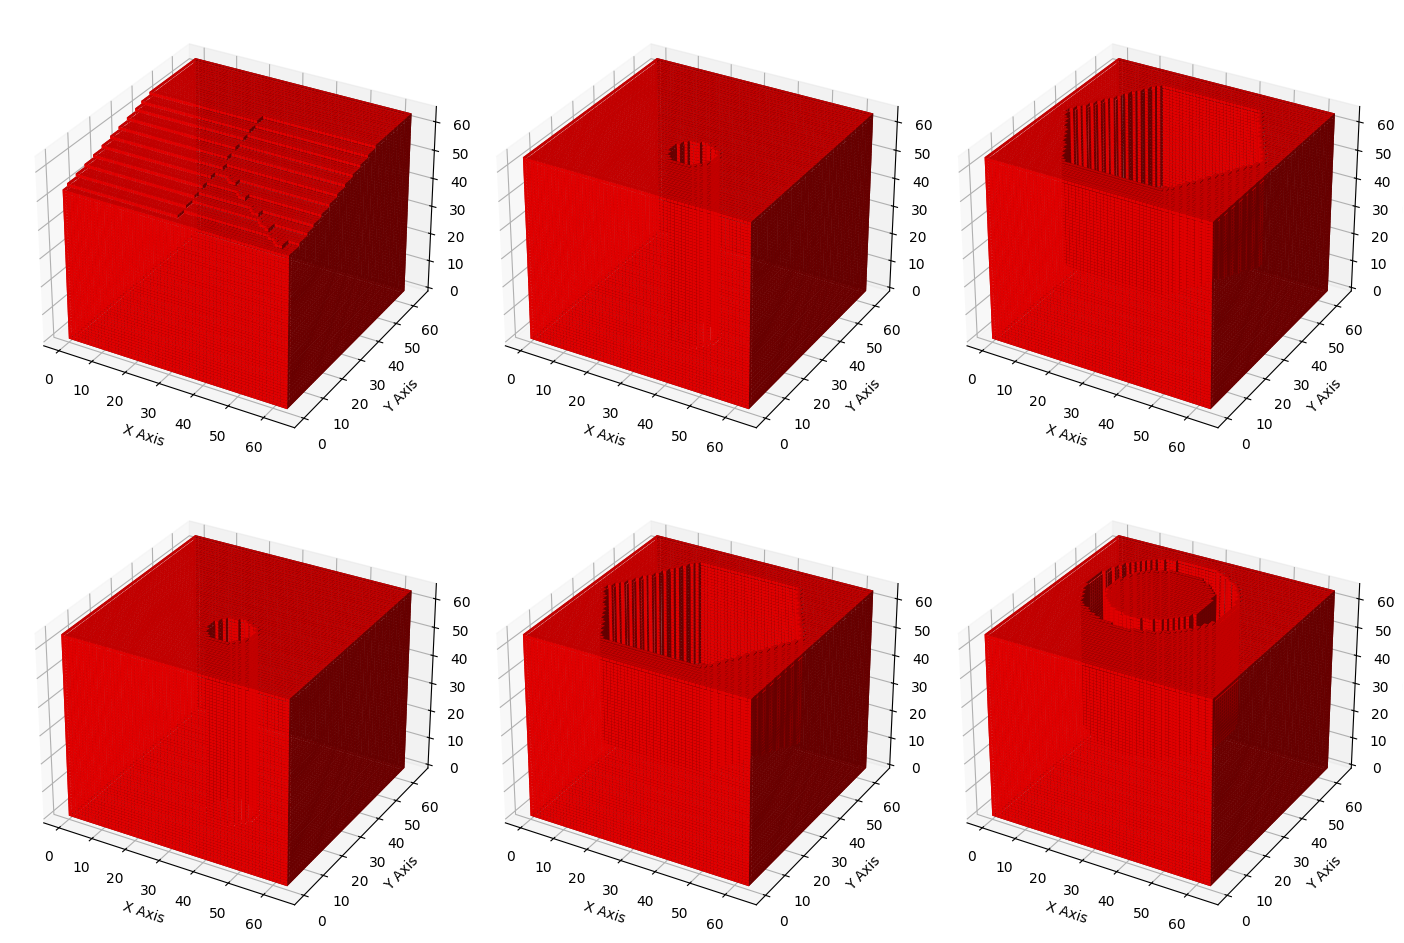

In [ ]:
# Replace this tensor with your actual voxel data
voxel_tensor = data[0]  # Your tensor data goes here

# Convert the tensor to a NumPy array
voxel_arrays = voxel_tensor.cpu().numpy()

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(14, 10), subplot_kw={'projection': '3d'})  # 2 rows, 3 columns

batch_size = flags['Data']['train']['batch_size']
random_idx = random.sample(range(batch_size), 6)

# Loop through each subplot position and plot 3D objects
for i in range(2):  # Rows
    for j in range(3):  # Columns
        voxel_array = voxel_arrays[random_idx[i+j]][0]

    
        voxel_rotate = np.rot90(voxel_array, 1, (0, 1))
        voxel_rotate = np.rot90(voxel_rotate, 1, (1, 2))
        voxel_rotate = np.rot90(voxel_rotate, 3, (0, 2))
        
        axes[i, j].voxels(voxel_rotate, facecolors='r', linewidth=0.01, edgecolor='k')  # Example plot data
        axes[i, j].set_xlabel('X Axis')
        axes[i, j].set_ylabel('Y Axis')
        axes[i, j].set_zlabel('Z Axis')

# Display the plot
plt.tight_layout()

plt.show()



For classification the labels are changed to one-hot value here we show how it would look.

In [38]:
one_hot = torch.nn.functional.one_hot(data[1], num_classes=24)
print(one_hot)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0

As you can see are dataloader works just fine and we have the data and the labels.

## Step 2: Neural Network Setup

In [ ]:
# Importing dependencies

import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import confusion_matrix
from torch.autograd import grad, Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR


import yaml
# load configuration of this neural network
flags = yaml.safe_load(open('FN_param.yaml'))

Defining the Neural Network

In [21]:
class FeatureNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(FeatureNet, self).__init__()
        conv1_channels = 32  
        conv2_channels = 32 
        conv3_channels = 64  
        conv4_channels = 64
          
        
        self.conv1 = nn.Sequential(
            
            #Conv layer 1 
            nn.Conv3d(
                in_channels=in_channels, out_channels=conv1_channels, kernel_size=7,
                stride=2, padding=3, bias=True
            ),  # set kernel size, stride (movement) and padding around the data structure
           
           nn.BatchNorm3d(conv1_channels),
            
            nn.ReLU(),  # relu as the activation function
        
        )
         
        self.conv2 = nn.Sequential(   
            #Conv layer 2 
            nn.Conv3d(
                in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=5,
                stride=1, padding=2, bias=True
            ),  # set kernel size, stride (movement) and padding around the data structure

            nn.ReLU(),  # relu as the activation function

        )
        self.conv3 = nn.Sequential(
            #Conv layer 3 
            nn.Conv3d(
                in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=5,
                stride=1, padding=2, bias=True
            ),  # set kernel size, stride (movement) and padding around the data structure

            nn.ReLU(),  # relu as the activation function
        )
        
        self.conv4 = nn.Sequential(
            #Conv layer 4 
            nn.Conv3d(
                in_channels=conv3_channels, out_channels=conv4_channels, kernel_size=3,
                stride=1, padding=1, bias=True
            ),  # set kernel size, stride (movement) and padding around the data structure

            nn.ReLU(),  # leaky relu as the activation function
        )
        
        self.fc = nn.Sequential(
            #Max pooling
            nn.MaxPool3d(kernel_size=2, stride=2, padding=0),
            
            #Flatten
            nn.Flatten(),
            
            #fc 1
            nn.Linear(16**3*conv4_channels, 128),
            nn.ReLU(),

            #fc2
            nn.Linear(128, n_classes)#,
            
#             nn.Softmax(dim=1)
            
        )
 
            

    def forward(self, input):
        # Set 1
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        output = self.fc(x)
        
        return output

Now, we can train our Neural Network

In [22]:
# loading the dataset
# Root path for the folder containing voxelized data
data_dir = os.path.join("..", "00-FeatureNet-Dataset", "binvox_64-64-64-No_Rotation")
dataset = featurenet_loader(flags, operation='train', normal=False, rotation=False)

# Split dataset into train/val/test
dataset_split = {"train": 0.7, "val": 0.15, "test": 0.15}

train_size = int(dataset_split['train'] * len(dataset))
val_size = int(dataset_split['val'] * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

Let's take a look at what is the sizes of our train, validation and test dataset. 

In [23]:
print(train_size)
print(val_size)
print(test_size)

11758
2519
2521


In [ ]:
N_ClASESS = 24
IN_CHANNELS = 1
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU when available

model = FeatureNet(flags['Data']['in_channels'], flags['Data']['num_class'])
model.to(device)
model.train()

FeatureNet(
  (conv1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
  )
  (fc): Sequential(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=262144, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=24, bias=True)
  )
)

In [ ]:
N_EPOCH = 2 # Change this to 100 for full training
BATCH_SIZE = 32
N_ClASESS = 24
INITIAL_LR = 0.00001
DECAY_RATE = 0.93
EVERY_EPOCH = 5


# Data related parameters
IN_CHANNELS = 1
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU when available

model = FeatureNet(IN_CHANNELS, N_ClASESS)
model.to(device)
model.train()

#print(model)

# Loss function : Cross Entropy
error = nn.CrossEntropyLoss()

# optimizer Adam
optimizer = torch.optim.Adam(model.parameters(), INITIAL_LR)

scheduler = ExponentialLR(optimizer, gamma=DECAY_RATE)

def acc_func(predicted, targets):          
    c=0
    d=0
    for i in range(len(targets)):
        for j in range(len(targets[i])):
            d+=1
            if (predicted[i][j] == targets[i][j]):
                c+=1
    accuracy =  100 * c / d
    return(accuracy)



# Placeholder for stats
training_loss_list = []
validation_loss_list = []

training_acc_list = []
validation_acc_list = []

# Additional Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU when available                
for epoch in tqdm(range(N_EPOCH)):
    torch.cuda.empty_cache()
    
    model.train()
    # Initialize dataloader at the start of each epoch
    batch_index = 0  # reset batch_index
    
    # Create training loader instance as an iterable. Specify batch size and randomizing conditions
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    train_avg_loss = 0
    # Looping through the Batches in the Dataloader
    for index, (shapes, labels) in enumerate(train_loader):
        
        
        # data type problem | "expected scalar type int but found float"
        shapes = shapes.to(device).float()
        labels = labels.to(device)
        
        # Zero out the gradients (to avoid accumulation from previous iterations).
        optimizer.zero_grad()
        
        # Perform a forward pass through the model to get predictions
        outputs = model(shapes)
        

        # Calculate the loss between predictions and actual values

        #Perform a backward pass to compute gradients  
        training_loss = error(outputs, labels)
        train_avg_loss += training_loss.data
        
        # Backpropagation
        training_loss.backward(retain_graph=False)
        
        # Update parameters using Adam optimizer 
        optimizer.step()
        

    # Chnage the learning rate
    scheduler.step()


     #calculate the accuracy using test validation_data
    if epoch % EVERY_EPOCH == 0:

        # Prepare a list of correct results and a list of anticipated results.     
        listlabels=[]
        listpredicted=[]

        # Defining val_loader
        val_loader = iter(DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True))

        # val_loader
        val_avg_loss = 0
        for j in range(len(val_loader)):
            shapes, labels = val_loader.next()

            # Type correction
            shapes = shapes.to(device).float()
            labels = labels.to(device)
            # labels = torch.nn.functional.one_hot(labels, num_classes=N_ClASESS)

            # Forward propagation
            outputs = model(shapes)

            # Compute the validation loss (argmex(-1) is inverse of one-hot)   
            validation_loss = error(outputs, labels)
            val_avg_loss += validation_loss.data

            listlabels.append(labels)
            listpredicted.append(outputs.argmax(-1))


        # calculate Accuracy
        val_acc= acc_func(listpredicted, listlabels)
        
        print('epoch: {}  Training_loss: {}  Validation_loss {}, Validation_accuracy: {} %'.format(
            epoch, train_avg_loss/len(train_loader), val_avg_loss/len(val_loader), val_acc))

        # store loss and accuracy. They'll be required to print the curve.
        training_loss_list.append(training_loss.data)
        validation_loss_list.append(val_avg_loss/len(val_loader))
        validation_acc_list.append(val_acc)
        
        if len(validation_loss_list) > 1 and validation_loss_list[-2] > validation_loss_list[-1]:
            # Save the model state to a file
            torch.save(model.state_dict(), 'FeatureNet_Main_run.pth')   
     

  0%|          | 0/2 [00:00<?, ?it/s]

## Step 3: Neural Network Results


The results section includes:

- A training log displaying the training and validation loss.
- A training log showing the validation dataset's accuracy percentage.
- The network's accuracy on the testing set.
- A confusion matrix illustrating the network's performance on the testing set.


In [ ]:
# Load model and its configuration
#--- Load dataloader
#--- Load model

import yaml
# load configuration of this neural network
flags = yaml.safe_load(open('FN_param.yaml'))

model = FeatureNet(flags['Data']['in_channels'], flags['Data']['num_class'])
model.load_state_dict(torch.load('FeatureNet_Main_run.pth', map_location=torch.device('cpu')))
model.eval()

FeatureNet(
  (conv1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
  )
  (fc): Sequential(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=262144, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=24, bias=True)
  )
)

### 3.3 Test dataset accuracy

In [7]:
def acc_func(predicted, targets):          
    c=0
    d=0
    for i in range(len(targets)):
        for j in range(len(targets[i])):
            d+=1
            if (predicted[i][j] == targets[i][j]):
                c+=1
    accuracy =  100 * c / d
    return(accuracy)

In [ ]:
test_dataset = featurenet_loader(flags,operation='test', normal=True, rotation=False)
test_loader = iter(DataLoader(dataset=test_dataset, batch_size=flags['Data']['test']['batch_size'], shuffle=False))
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU when available

# Prepare a list of correct results and a list of anticipated results.     
listlabels=[]
listpredicted=[]

for j in range(len(test_loader)):
    
    shapes, labels = test_loader.__next__()

    # Type correction
    shapes = shapes.to(device).float()
    labels = labels.to(device)


    # Forward propagation
    outputs = model(shapes)

    listlabels.append(labels)
    listpredicted.append(outputs.argmax(-1)) 

test_acc= acc_func(listpredicted, listlabels)
print(f"Accuracy {test_acc}")

96.69260700389106


### 3.4 Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

predicted_labels_list = [tensor.tolist() for tensor in listpredicted]
flattened_Predicted_labels = [label for sublist in predicted_labels_list for label in sublist]

true_labels_list = [tensor.tolist() for tensor in listlabels]
flattened_true_labels = [label for sublist in true_labels_list for label in sublist]



In [ ]:
flattened_true_labels
# Create a DataFrame from the list
df = pd.DataFrame({"Labels": flattened_true_labels})

# Save DataFrame to Excel file
df.to_excel("flattened_true_labels.xlsx", index=False)

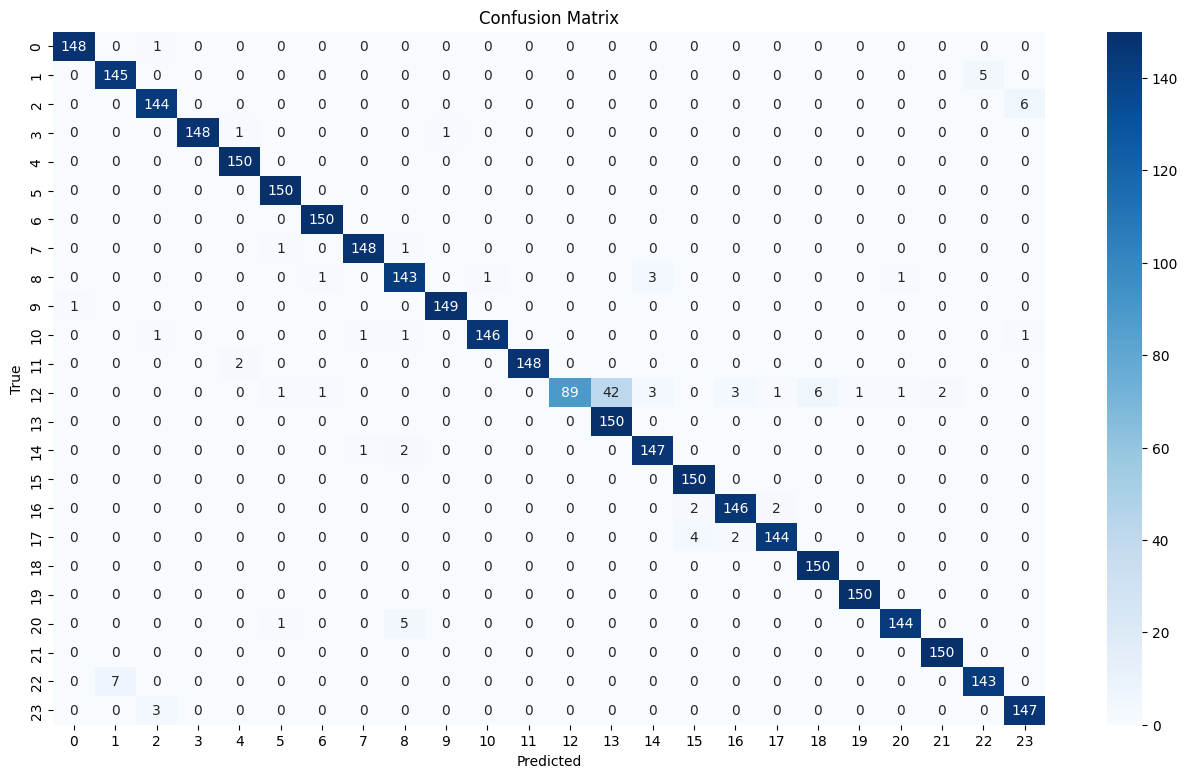

In [ ]:
import numpy as np

import seaborn as sns


# Compute confusion matrix
cm = confusion_matrix(flattened_true_labels , flattened_Predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


This part identifies misclassified test samples by comparing true and predicted labels, extracts their filenames and incorrect labels, and saves the results in an Excel file for analysis.

In [ ]:
# I want to know the features that were inaccuractly classified
# Make the suffle off in the dataloader

# load the file list for test data
filelist = flags['Data']['test']['filelist']
with open(filelist, 'r') as file:
    filelist = [line.rstrip('\n') for line in file.readlines()]
    

wrong_pred_idx= [i for i, (elem1, elem2) in enumerate(zip(flattened_true_labels, flattened_Predicted_labels)) if elem1 != elem2]
wrong_pred_name = [filelist[i] for i in wrong_pred_idx]
wrong_pred_label = [flattened_Predicted_labels[i] for i in wrong_pred_idx]

wrong_pred_info = list(zip(wrong_pred_name, wrong_pred_label))


# Create a DataFrame from the list
df = pd.DataFrame({"Labels": wrong_pred_info})

# Save DataFrame to Excel file
df.to_excel("wrong_pred_info.xlsx", index=False)
    